# Cleaning Reddit Datasets
Defines a bunch of cleaning functions and general guidelines for keeping datasets consistent across notebooks 
Functions are designed to be able to easily change what gets cleaned.



# Import all the stuff

In [1]:
%load_ext dotenv
%dotenv

import numpy as np
import csv as csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import json
import os
from datetime import datetime
import seaborn as sns
import re

from nltk import pos_tag
from nltk.util import pad_sequence
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from termcolor import colored

import praw
import requests
import json
import os
import glob
import calendar

from sklearn.model_selection import train_test_split


os.chdir('/homes/gws/taugust/Projects/ARK/community_guidelines/')

# check for if we want to be exporting currently
EXPORTING = True 
THRESHOLD_WORD_COUNT = 10


# Cleaning posts - Changed back to 2018

In [5]:
### Get all csvs 
extension = 'csv'
all_post_csvs = [i for i in glob.glob('data/subs_2018/posts/reddit_posts_2018_*.{}'.format(extension))]
print(len(all_post_csvs))



10


In [6]:
### build full post df
df_list = []

for csv_file in all_post_csvs:
    df = pd.read_csv(csv_file,index_col=None, header=0)
    df_list.append(df)
    
df_posts = pd.concat(df_list, axis = 0, ignore_index = True)
print('original number of posts:', len(df_posts))

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,21,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,21,24,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


original number of posts: 5749974


In [7]:
print('original number of posts:', len(df_posts))

### clean the data
df_posts_cleaned = df_posts.copy()

### drop any nan text
df_posts_cleaned = df_posts_cleaned.dropna(subset=['title']) # added and hasnt been run

### replace any nan text with '' - need this for adding to fulltext later
df_posts_cleaned[['title', 'selftext']] = df_posts_cleaned[['title', 'selftext']].fillna(' ')

# creating new columns 
# create a full text column for both the title and selftext
df_posts_cleaned['fulltext'] = df_posts_cleaned['title'] + df_posts_cleaned['selftext']

# create a month column 
df_posts_cleaned['created_month'] = df_posts_cleaned['created_utc'].apply(lambda x: datetime.fromtimestamp(x).month)

### break up the string into words -- takes a little while
### NOTE this isn't word_tokenize since that takes way too long
### words and word_count will not be perfect, but will provide a rough estimate
df_posts_cleaned['words'] = [x.split(' ') for x in df_posts_cleaned['fulltext']]

### get word counts 
df_posts_cleaned['word_count'] = [len(x) for x in df_posts_cleaned['words']]

### get only comments with more than 10 (giving a little lee-way rather than >=) words:
df_posts_cleaned =  df_posts_cleaned[df_posts_cleaned['word_count'] > THRESHOLD_WORD_COUNT]
print('number of posts greater than ', THRESHOLD_WORD_COUNT ,' words:', len(df_posts_cleaned))

### replace any characters that could mess up the csv writing 
df_posts_cleaned.fulltext = df_posts_cleaned.fulltext.str.replace('\\\\', '')
df_posts_cleaned.title = df_posts_cleaned.title.str.replace('\\\\', '')
df_posts_cleaned.selftext = df_posts_cleaned.selftext.str.replace('\\\\', '')

# ignore r/gaming - decided to not be in the full dataset
df_posts_cleaned = df_posts_cleaned[df_posts_cleaned['subreddit'] != 'gaming']

### remove any deleted or removed posts
df_posts_cleaned_deleted = df_posts_cleaned[df_posts_cleaned['selftext'].isin(['[deleted]', '[removed]'])]
df_posts_cleaned = df_posts_cleaned[df_posts_cleaned['selftext'].apply(lambda x: x not in ['[deleted]', '[removed]'])]
print('number of non-deleted/removed posts:', len(df_posts_cleaned))


### seperate moderator posts
df_posts_cleaned_mod = df_posts_cleaned[df_posts_cleaned['distinguished'] == 'moderator'].copy()
print('number of moderator posts:', len(df_posts_cleaned_mod))
df_posts_cleaned = df_posts_cleaned[df_posts_cleaned['distinguished'] != 'moderator'].copy()
print('number of non-moderator posts:', len(df_posts_cleaned))

original number of posts: 5749974
number of posts greater than  10  words: 3109179
number of non-deleted/removed posts: 1801460
number of moderator posts: 393
number of non-moderator posts: 1801067


In [8]:
df_posts_cleaned.subreddit.value_counts()

AskReddit    1096947
news          254201
politics      211866
funny         114272
pics          101624
science        22157
Name: subreddit, dtype: int64

Text(0.5, 1.0, 'Count of posts by month')

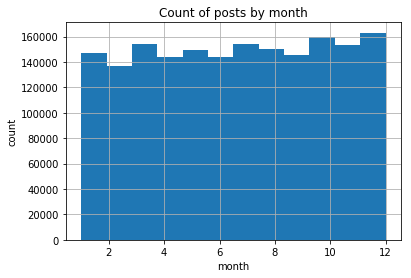

In [9]:

# Visualize all reddit data by month
ax = df_posts_cleaned['created_month'].hist(bins=12)
ax.set_xlabel('month')
ax.set_ylabel('count')
ax.set_title('Count of posts by month')

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


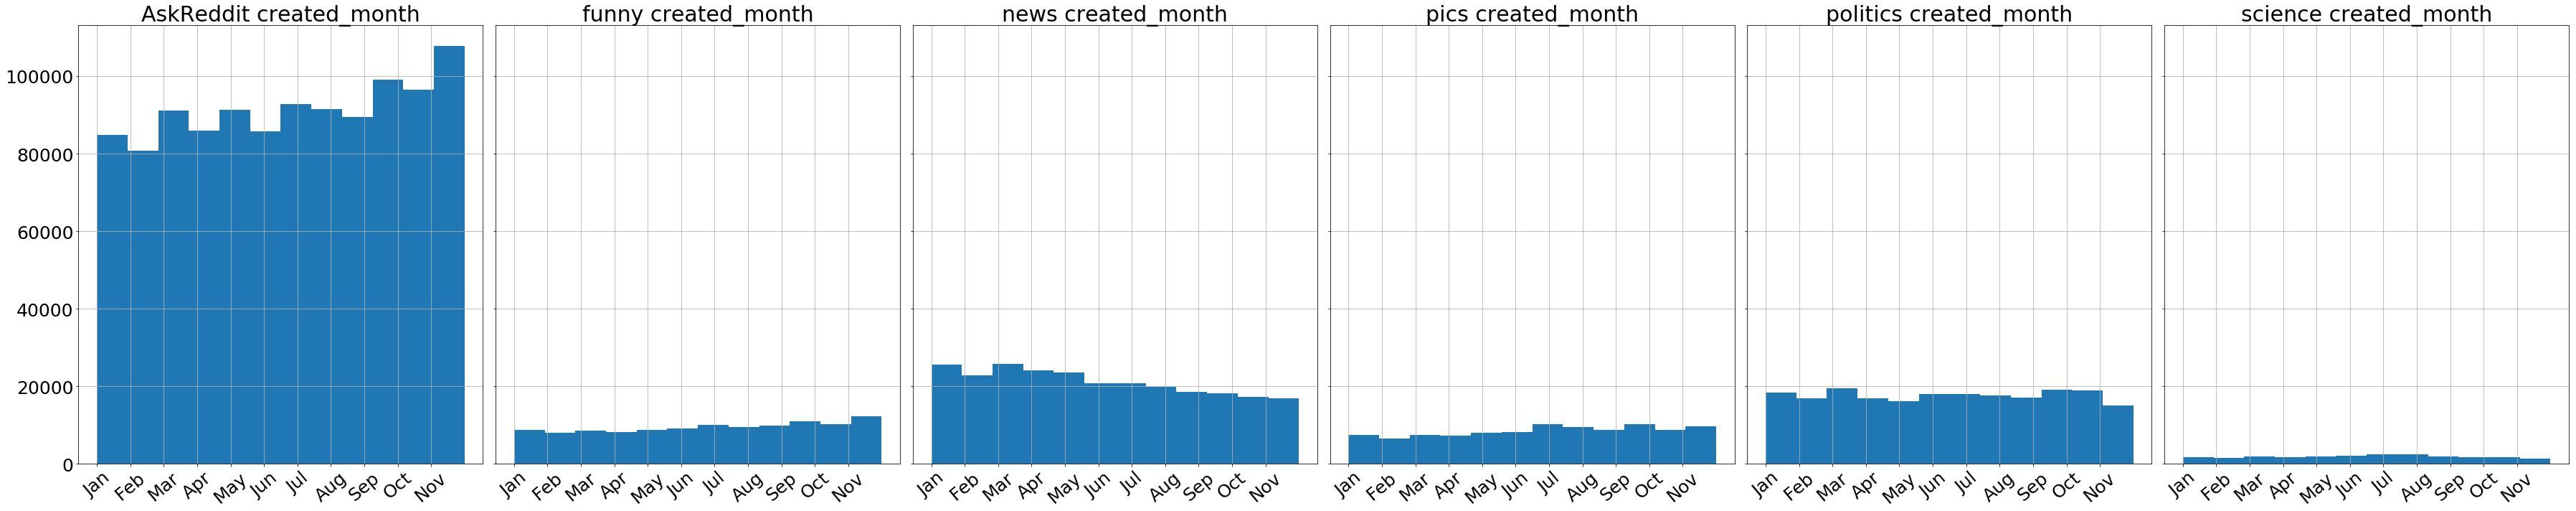

In [10]:
### visualize counts for each subreddit by month
def plot_multiple_hist(df, grouping, column, xlabels):
    groups = df.groupby(grouping)
    fig, axs = plt.subplots(1, len(groups), sharey=True, tight_layout=True)
    fig.set_figheight(10)
    fig.set_figwidth(50)
    for i, (sub, g) in enumerate(groups):
        g[column].hist(ax=axs[i], bins=12)
        axs[i].set_title(sub + ' ' + column, fontsize=30)
        axs[i].set_xticks(range(1,12))
        axs[i].set_xticklabels(labels=xlabels, rotation=40)
        axs[i].tick_params(axis='both', which='major', labelsize=25)
    fig.show()

month_list = [calendar.month_abbr[i] for i in range(1,12)]
plot_multiple_hist(df_posts_cleaned, 'subreddit', 'created_month', month_list)


In [18]:
# ### Just testing how well the distribution works for test/train split
# plot_multiple_hist(df_posts_train, 'subreddit', 'created_month', month_list)
# plot_multiple_hist(df_posts_test, 'subreddit', 'created_month', month_list)


In [19]:
### export the data to a cleaned csv 
if EXPORTING:
    ### split into test and train - note that we actually don't end up using this test/train split
    # instead we define it on the author level at the end of this notebook
    df_posts_train, df_posts_test = train_test_split(df_posts_cleaned, test_size=0.1, random_state=100)

    df_posts_train.to_csv('data/cleaned/train/2018/posts/real_subs_df_posts_train_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    df_posts_test.to_csv('data/cleaned/test/2018/posts/real_subs_df_posts_test_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    
    df_posts_cleaned.to_csv('data/cleaned/real_subs_cleaned_posts_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    df_posts_cleaned_mod.to_csv('data/cleaned/real_subs_cleaned_mod_posts_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    
    
    df_posts_cleaned_deleted.to_csv('data/cleaned/real_subs_cleaned_deleted_posts_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')

In [20]:
# double check that posts read/write correctly
print('Double checking that posts write/read to csv correctly')
df_posts_cleaned_check = pd.read_csv('data/cleaned/real_subs_cleaned_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
print(len(df_posts_cleaned), len(df_posts_cleaned_check)) 
print(len(df_posts_cleaned_check))

Double checking that posts write/read to csv correctly


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,21,28,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


115051 115051
115051


In [2]:
# output only science related subs posts
science_related_subs = ['science', 'AskHistorians', 'EverythingScience', 'Futurology', 'TrueReddit', 'dataisbeautiful', 'askscience']
df_posts_cleaned_check = pd.read_csv('data/cleaned/real_subs_cleaned_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
df_posts_cleaned_only_science = df_posts_cleaned_check[df_posts_cleaned_check['subreddit'].isin(science_related_subs)]
df_posts_cleaned_only_science.to_csv('data/cleaned/real_subs_cleaned_posts_2018_science_related.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,21,28,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Cleaning comments - changed to 2018

In [22]:
### Get all csvs 
extension = 'csv'
all_comment_csvs = [i for i in glob.glob('data/subs_2018/comments/new_subs_2018_comments_*.{}'.format(extension))]

print(len(all_comment_csvs))

10


In [23]:
### build full comments df
df_list = []

for csv_file in all_comment_csvs:
    df = pd.read_csv(csv_file,index_col=None, header=0)
    df_list.append(df)
    
df_comments = pd.concat(df_list, axis = 0, ignore_index = True)
print('original number of comments:', len(df_comments))

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


original number of comments: 4357944


In [24]:

# ### copy the data
df_comments_cleaned = df_comments.copy()


# ignore r/gaming
df_comments_cleaned = df_comments_cleaned[df_comments_cleaned['subreddit'] != 'gaming']

In [25]:
### take out any empty body posts
df_comments_cleaned = df_comments_cleaned.dropna(subset=['body']) 


In [26]:
### create a month column 
df_comments_cleaned['created_month'] = df_comments_cleaned['created_utc'].apply(lambda x: datetime.fromtimestamp(x).month)


In [28]:
### replace any characters that could mess up the csv writing 
df_comments_cleaned.body = df_comments_cleaned.body.str.replace('\\\\', '')


In [29]:
### seperate automod comments out
df_comments_auto_mod = df_comments_cleaned[df_comments_cleaned['author'] == 'AutoModerator'].copy()
print('number of auto mod comments:', len(df_comments_auto_mod))


number of auto mod comments: 27756


In [30]:
### get all mod posts
df_comments_mod = df_comments_cleaned[df_comments_cleaned['distinguished'].isin(['moderator', 'admin'])].copy()
print('number of mod and admin comments (not automod)', len(df_comments_mod))



number of mod and admin comments (not automod) 103911


In [31]:
# %%writefile dataset_fix.py
# import numpy as np
# import csv as csv
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib
# import math
# import json
# import os
# from datetime import datetime
# import seaborn as sns
# import re

# from nltk import pos_tag
# from nltk.util import pad_sequence
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
# from termcolor import colored

# import praw
# import requests
# import json
# import os
# import glob
# import calendar


# os.chdir('/homes/gws/taugust/ARK/community_guidelines/')

# print('Done with import, getting to data.')

# # check for if we want to be exporting currently
# EXPORTING = True 
# THRESHOLD_WORD_COUNT = 10

# print('Importing....', end='')
# df_comments_cleaned = pd.read_csv('data/cleaned/real_subs_cleaned_comments_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
# print('Done')

# df_comments_cleaned = df_comments_cleaned.dropna(subset=['body']) 
# df_comments_cleaned['words'] = [x.split(' ') for x in df_comments_cleaned['body']]
# df_comments_cleaned['word_count'] = [len(x) for x in df_comments_cleaned['words']]
# df_comments_cleaned =  df_comments_cleaned[df_comments_cleaned['word_count'] > THRESHOLD_WORD_COUNT]
# print('number of comments greater than ', THRESHOLD_WORD_COUNT ,' words:', len(df_comments_cleaned))
# # ### seperate deleted posts
# # df_comments_deleted = df_comments_cleaned[df_comments_cleaned['author'] == '[deleted]'].copy()
# # print('number of deleted comments:', len(df_comments_deleted))
# ### remove all deleted or removed posts
# df_comments_cleaned = df_comments_cleaned[df_comments_cleaned['author'].apply(lambda x: x not in ['[deleted]', 'AutoModerator'])].copy()
# print('number of comments w/o autmod and deleted:', len(df_comments_cleaned))
# ### remove all mod/admin posts
# df_comments_cleaned = df_comments_cleaned[df_comments_cleaned['distinguished'].apply(lambda x: x not in ['moderator', 'admin'])].copy()
# print('number of non-mod and admin comments', len(df_comments_cleaned))
# ### seperate words into a diff dataframe for export reasons
# # df_words = df_comments_cleaned[['words', 'id']].copy()
# df_comments_cleaned = df_comments_cleaned.drop('words', axis=1)
# print('Done with cleaning')

# # fixing weird word count issue
# cols = df_comments_cleaned.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# df_comments_cleaned = df_comments_cleaned[cols]

# ### split into test and train
# #     df_comments_train, df_comments_test = train_test_split(df_comments_cleaned, test_size=0.1, random_state=100)

# print('Exporting....', end='')
# df_comments_cleaned.to_csv('data/cleaned/real_subs_cleaned_comments_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
# print('Done')

In [32]:
df_comments_cleaned = df_comments_cleaned.dropna(subset=['body']) 


In [33]:
### break up the string into words -- takes a really long time
### NOTE (trying word_tokenize now) this isn't word_tokenize since that takes way too long,
### words and word_count will not be perfect, but will provide a rough estimate that will have to be good enough
df_comments_cleaned['words'] = [x.split(' ') for x in df_comments_cleaned['body']]
print('Done')

Done


In [34]:
### get word counts 
df_comments_cleaned['word_count'] = [len(x) for x in df_comments_cleaned['words']]
print('Done')

Done


In [35]:
### get only comments with more than 10 (giving a little lee-way rather than >=) words:
df_comments_cleaned =  df_comments_cleaned[df_comments_cleaned['word_count'] > THRESHOLD_WORD_COUNT]
print('number of comments greater than ', THRESHOLD_WORD_COUNT ,' words:', len(df_comments_cleaned))


number of comments greater than  10  words: 2434576


In [36]:
### seperate deleted posts
df_comments_deleted = df_comments_cleaned[df_comments_cleaned['author'] == '[deleted]'].copy()
print('number of deleted comments:', len(df_comments_deleted))


number of deleted comments: 17738


In [37]:
### remove all deleted or removed posts
df_comments_cleaned = df_comments_cleaned[df_comments_cleaned['author'].apply(lambda x: x not in ['[deleted]', 'AutoModerator'])].copy()
print('number of comments w/o autmod and deleted:', len(df_comments_cleaned))


number of comments w/o autmod and deleted: 2389082


In [38]:
### remove all mod/admin posts
df_comments_cleaned = df_comments_cleaned[df_comments_cleaned['distinguished'].apply(lambda x: x not in ['moderator', 'admin'])].copy()
print('number of non-mod and admin comments', len(df_comments_cleaned))



number of non-mod and admin comments 2315519


In [39]:
### seperate words into a diff dataframe for export reasons
# df_words = df_comments_cleaned[['words', 'id']].copy()

df_comments_cleaned = df_comments_cleaned.drop('words', axis=1)
print('Done')


Done


In [40]:
### Export
if EXPORTING:
    # fixing weird word count issue
    cols = df_comments_cleaned.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_comments_cleaned = df_comments_cleaned[cols]
    
    ### split into test and train
#     df_comments_train, df_comments_test = train_test_split(df_comments_cleaned, test_size=0.1, random_state=100)
    
    df_comments_cleaned.to_csv('data/cleaned/real_subs_cleaned_comments_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
#     df_comments_train.to_csv('data/cleaned/train/2018/comments/real_subs_df_comments_train_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
#     df_comments_test.to_csv('data/cleaned/test/2018/comments/real_subs_df_comments_test_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')

#     df_words.to_csv('cleaned/cleaned_comments_words_2017.csv')
#     df_comments_mod.to_csv('data/cleaned/cleaned_mod_comments_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
#     df_comments_auto_mod.to_csv('data/cleaned/real_subs_cleaned_auto_mod_comments_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
#     df_comments_deleted.to_csv('data/cleaned/real_subs_cleaned_comments_deleted_2018.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
    print('Done')


Done


In [2]:
# double check that comments read/write correctly
print('Double checking that comments write/read to csv correctly')
df_comments_cleaned_check = pd.read_csv('data/cleaned/real_subs_cleaned_comments_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
print(len(df_comments_cleaned_check)) 

Double checking that comments write/read to csv correctly
2315519


In [3]:
df_comments_cleaned_check

,word_count,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,...,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_month
0,19,One learns to deal with the strings and inflex...,NaN,NaN,NaN,GarmWintersmith,NaN,NaN,1522351640,t5_mouw,...,1,1525726643,0,0,dwhp4cb,science,NaN,NaN,NaN,3
1,232,"Cool, I'm done too. When someone's argument d...",NaN,NaN,NaN,PACK_81,NaN,NaN,1520031866,t5_2tk95,...,1,1524751724,0,0,dv3gn3a,dataisbeautiful,NaN,NaN,NaN,3
2,61,Because the government is supposed to exist so...,NaN,NaN,NaN,try_____another,NaN,NaN,1522366556,t5_2t7no,...,1,1525735353,0,0,dwi4shg,Futurology,NaN,NaN,NaN,3
3,162,Land Value and Property value can both be spec...,NaN,NaN,NaN,cameronlcowan,NaN,NaN,1522107396,t5_2qyt6,...,3,1525623726,0,0,dwc3qyx,TrueReddit,NaN,NaN,NaN,3
4,29,I think its wierd that they think they work as...,NaN,NaN,NaN,Zkootz,NaN,NaN,1522178225,t5_mouw,...,1,1525652792,0,0,dwdnbpu,science,NaN,NaN,NaN,3
5,37,The people that went in deep space for 50 year...,NaN,NaN,NaN,jgrunn,NaN,NaN,1520547078,t5_2t7no,...,19,1524961681,0,0,dvedzqp,Futurology,NaN,NaN,NaN,3
6,71,Why would you say that MR are expensive to use...,NaN,NaN,NaN,lucaxx85,PhD|Medical Imaging|Nuclear Medicine,NaN,1522350047,t5_mouw,...,3,1525725660,0,0,dwhnbqt,science,NaN,NaN,med,3
7,35,"Honestly, after trying the Beyond Burgers, I’m...",NaN,NaN,NaN,Pikcle,NaN,NaN,1521838318,t5_2t7no,...,1,1525524353,0,0,dw6io8n,Futurology,NaN,NaN,NaN,3
8,49,"I'm seeing ""Item not available."" Per a differe...",NaN,NaN,NaN,chrisw428,OC: 2,NaN,1520549348,t5_2tk95,...,1,1524962891,0,0,dvegeq6,dataisbeautiful,NaN,NaN,ocmaker,3
9,44,I guess it depends on what you consider good a...,NaN,NaN,NaN,DrStealthE,NaN,NaN,1522439268,t5_mouw,...,1,1525764132,0,0,dwjogfy,science,NaN,NaN,NaN,3


/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


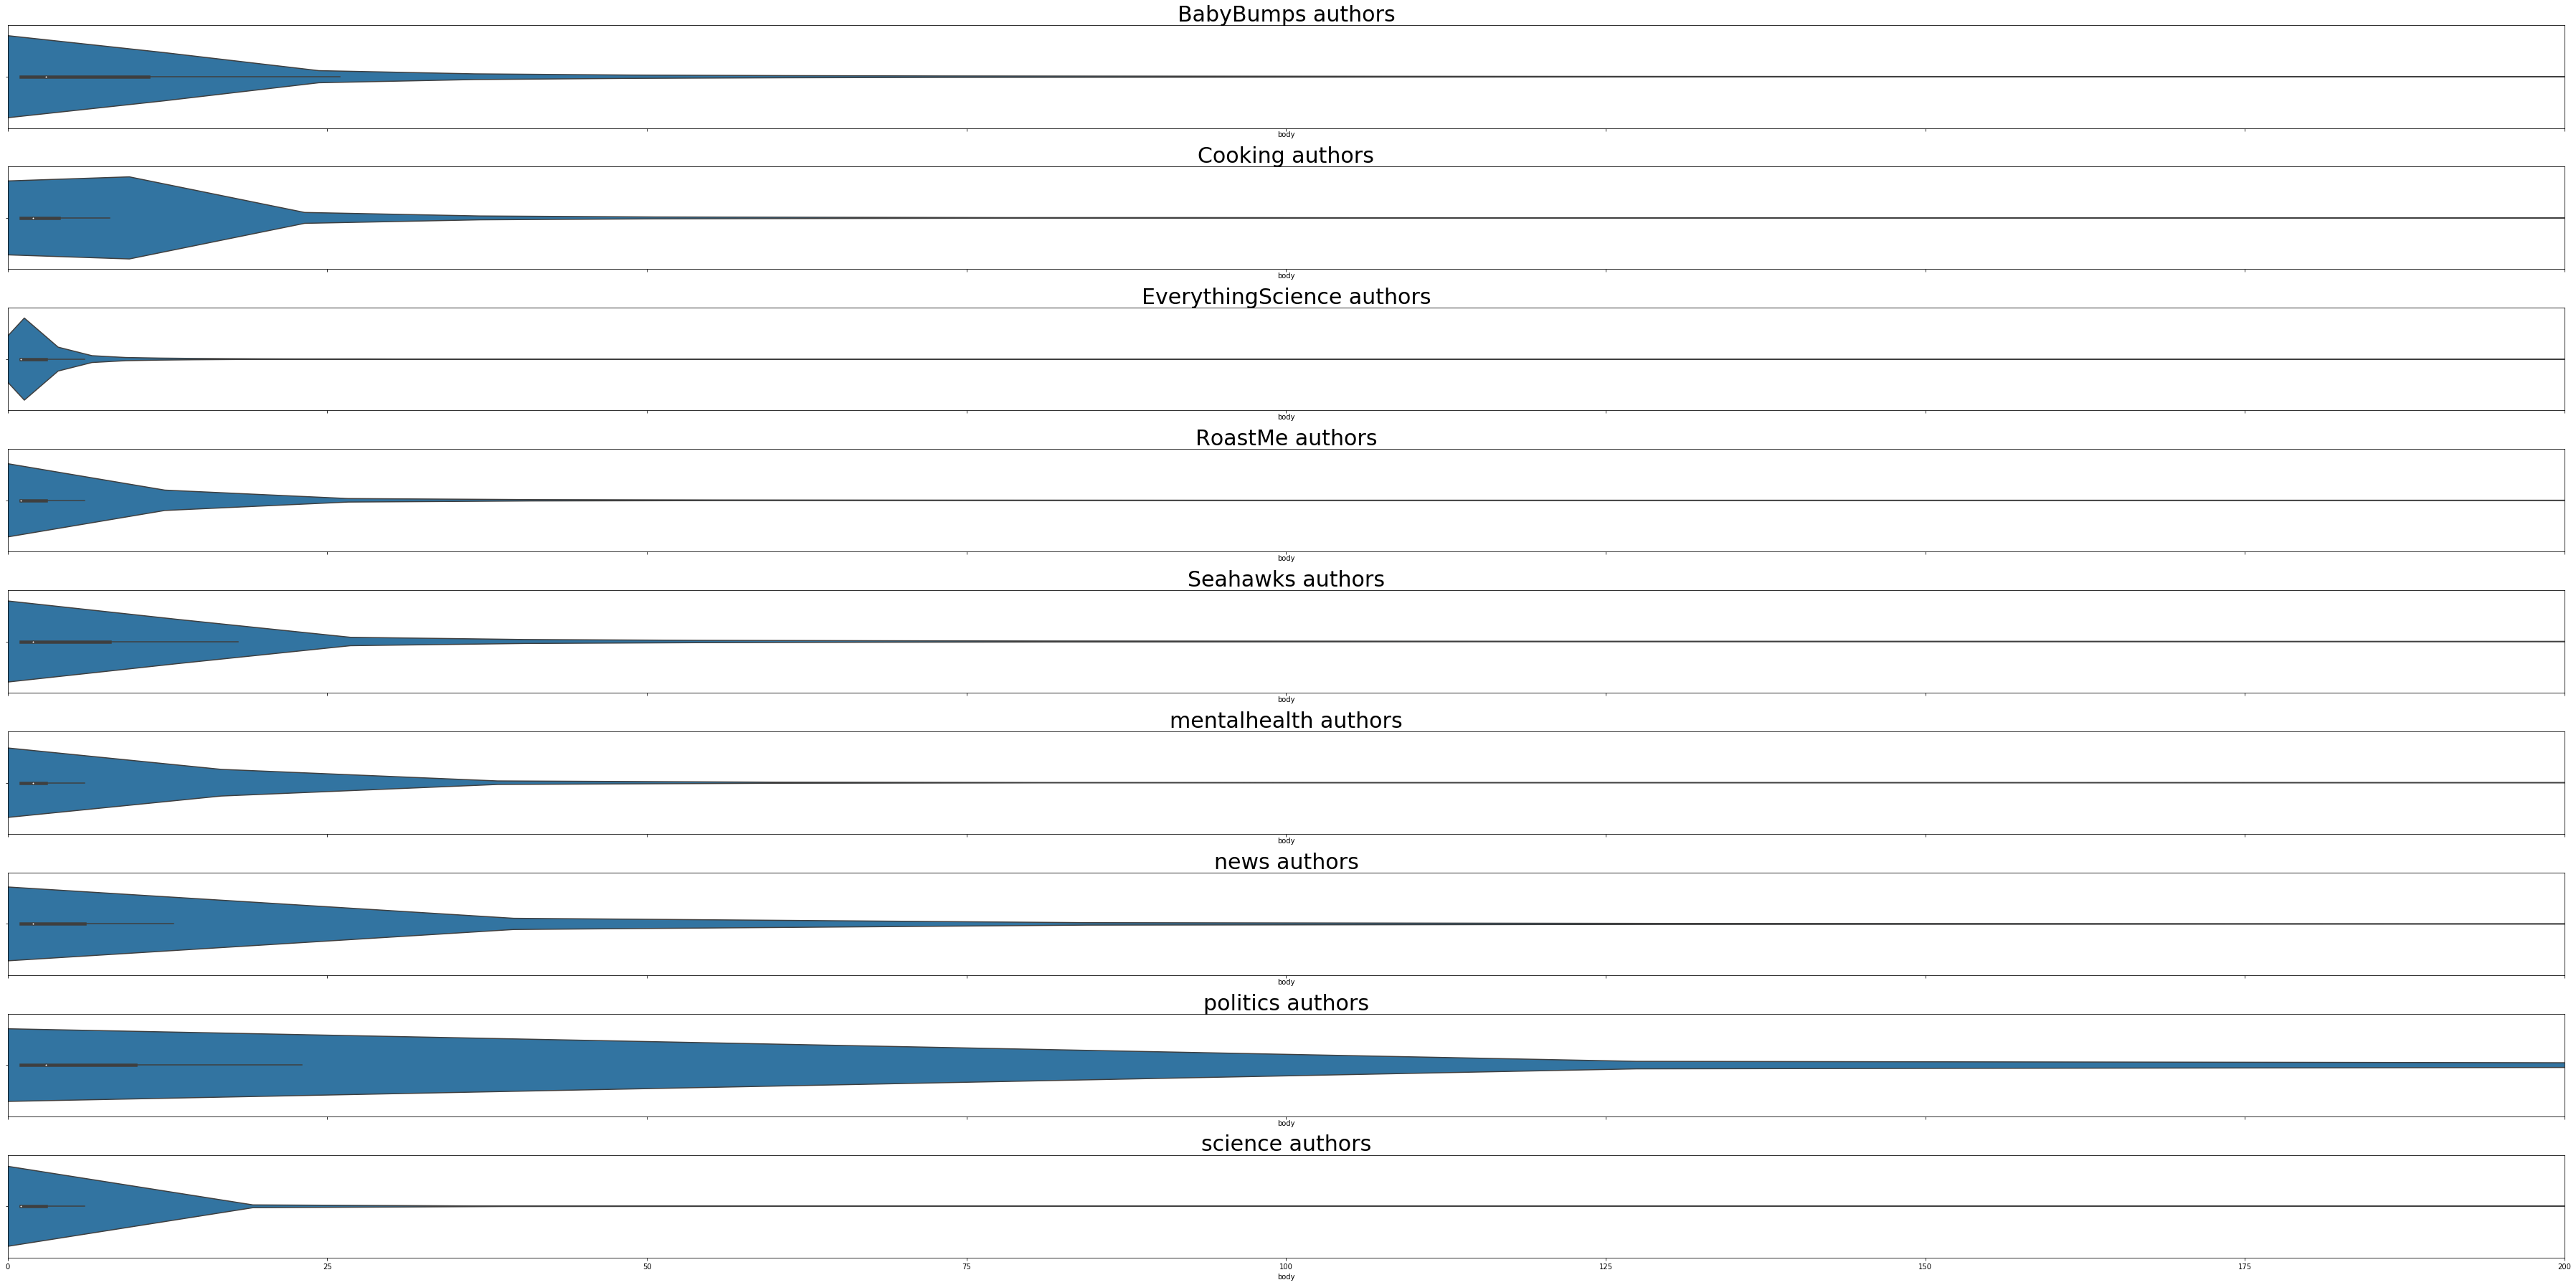

In [27]:
### Visualize subreddit based on number of author comments per author -- not working
df_comments['author_count'] = df_comments.groupby(['author'])['body'].transform('count') 
sub_groups = df_comments_cleaned.groupby('subreddit')
fig, axs = plt.subplots(len(sub_groups), 1, sharex=True, tight_layout=True)
fig.set_figheight(25)
fig.set_figwidth(50)
for i, (sub, g) in enumerate(sub_groups):
        axs[i].set_title(sub + ' authors', fontsize=30)
        author_count = g.groupby(['author']).agg('count')
        sns.violinplot(x='body', data=author_count, ax=axs[i])
        axs[i].set_xlim(0, 200)


In [28]:
# len_test = 0
# len_check = 0
# import re

# while len_test == len_check:
#     df_comments_cleaned_test = df_comments_cleaned.iloc[:1000000].sample(100000)
#     df_comments_cleaned_test.body.apply(lambda line: re.sub('\\\\', '', line))
#     df_comments_cleaned_test.to_csv('data/cleaned/cleaned_comments_2017_test.csv', index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
#     df_comments_cleaned_check_test = pd.read_csv('data/cleaned/cleaned_comments_2017_test.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
    
#     len_test = len(df_comments_cleaned_test)
#     len_check = len(df_comments_cleaned_check_test)
#     print(len_test, len_check)

In [29]:
# df_comments_cleaned_check_test[pd.isnull(df_comments_cleaned_check_test['body'])]

In [30]:

# display(df_comments_cleaned_check_test.iloc[62271:62274])
# df_comments_cleaned_check_test.iloc[62271].body

In [31]:
# display(df_comments_cleaned_test.iloc[62271:62274])
# df_comments_cleaned_test.iloc[62271].body

# Combining posts + comments
[optional] combine posts and comments into a single df to run in the SLMs, author counts will then be for combined posting and commenting


In [42]:
comment_cols = ['body', 'author', 'subreddit_id', 'subreddit', 'created_month', 'word_count', 'kind']
post_cols = ['fulltext', 'author', 'subreddit_id', 'subreddit', 'created_month', 'word_count', 'kind']

# since we don;t necessarily use this notebook linearly, 
# if the cleaned comments and posts don't exist yet, reload them
try:     
    df_posts_cleaned['kind'] = 'post'
    df_comments_cleaned['kind'] = 'comment'
except:
    print('reloading comments and posts...', end='')
    df_posts_cleaned = pd.read_csv('cleaned/real_subs_cleaned_posts_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\' )
    df_comments_cleaned = pd.read_csv('cleaned/real_subs_cleaned_comments_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')
    print('Done')


df_posts_comments = df_comments_cleaned[comment_cols].append(df_posts_cleaned[post_cols].rename(index=str, columns={'fulltext': 'body'}))

In [43]:
len(df_posts_comments), len(df_comments_cleaned) 

(2430570, 2315519)

# Break up into subreddits

In [12]:
### currently ignoring the train/test split
def export_subreddits(df, path, ext):
    sub_groups = df.groupby('subreddit')
    for sub, group in sub_groups:
        # rearrange columns to deal with weird word count issue
        cols = group.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        group = group[cols]
        save_path = path+sub+ext
        print('Exporting', colored(save_path, 'magenta'), '......', end=' ')
        if EXPORTING:
            group.to_csv(save_path,index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        else: 
            display(group)
        print('Done')

### comments

In [45]:
export_subreddits(df_comments_cleaned,path='data/cleaned/sub_comments/', ext='_comments_2018.csv')

Exporting data/cleaned/sub_comments/AskHistorians_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/EverythingScience_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/Futurology_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/TrueReddit_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/askscience_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/dataisbeautiful_comments_2018.csv ...... Done
Exporting data/cleaned/sub_comments/science_comments_2018.csv ...... Done


### posts

In [13]:
export_subreddits(df_posts_cleaned,path='data/cleaned/sub_posts/', ext='_posts_2018.csv')

Exporting data/cleaned/sub_posts/AskReddit_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/funny_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/news_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/pics_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/politics_posts_2018.csv ...... Done
Exporting data/cleaned/sub_posts/science_posts_2018.csv ...... Done


### Combined

In [47]:
export_subreddits(df_posts_comments,path='data/cleaned/sub_combined/2018/', ext='_combined_2018.csv')

Exporting data/cleaned/sub_combined/2018/AskHistorians_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/EverythingScience_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/Futurology_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/TrueReddit_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/askscience_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/dataisbeautiful_combined_2018.csv ...... Done
Exporting data/cleaned/sub_combined/2018/science_combined_2018.csv ...... Done


In [48]:
len(df_posts_comments), len(df_comments_cleaned)

(2430570, 2315519)

# Author Count Functions
Simple functions for import/export and extracting author counts

In [49]:
### function to return df with author counts for each month
def get_author_counts(df):
    author_counts = df.groupby(['created_month'])['author'].value_counts()
    author_counts = pd.DataFrame(author_counts).reset_index(0)
    author_counts.columns = ['created_month', 'count']
    
    # added for ease of importing
    author_counts['created_month'] = author_counts['created_month'].astype(int)

    month_groups = author_counts.groupby('created_month')
    for m, g in month_groups:
        author_counts[m] = g['count']
    
    author_counts = author_counts.fillna(0)
    
    # reset index now since we don't need authors to be an index for joining counts above
    author_counts = author_counts.reset_index()
    
    # also drop all the duplicates + unnecessary cols that this made
    author_counts = author_counts.drop_duplicates(subset=['author'])
    author_counts.drop(['created_month', 'count'], axis=1, inplace=True)
    
    return author_counts



# getting number of authors who posted at least one each month
def plot_author_counts(df_author_counts, ax, sub_name):
    counts = df_author_counts[range(1,13)].apply(lambda col: col.apply(lambda row: row > 0).sum(), axis=0)
    sns.barplot(x = counts.index, y=counts, ax=ax)
    axs[i].set_title(sub + 'author counts', fontsize=30)
    axs[i].set_xticks(range(1,12))
    axs[i].tick_params(axis='both', which='major', labelsize=25)
    
    
def export_author_counts(sub_name, df, path, ext, split_size=0.3, combined=True):
    print('Extracting author counts for', colored(sub_name, 'magenta'), '.....')
    
    print(len(df))
    # split df if combining 
    if combined:
        print(len(df[df['kind'] == 'comment']))
        df_post_author_counts = get_author_counts(df[df['kind'] == 'post'])
        df_post_author_counts['kind'] = 'post'
        df_comment_author_counts = get_author_counts(df[df['kind'] == 'comment'])
        df_comment_author_counts['kind'] = 'comment'
        author_counts = df_comment_author_counts.append(df_post_author_counts)
    else:
        author_counts = get_author_counts(df)
        
    ### split into test and train
    author_counts_train, author_counts_test = train_test_split(author_counts, test_size=split_size, random_state=100)
    
    # plotting both
#     fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#     plot_author_counts(author_counts_train, axs[0], sub_name+'_train')
#     plot_author_counts(author_counts_test, axs[1], sub_name+'_test')
    
#     fig.show()

    author_count_path_train = 'data/cleaned/train/2018/'+'author_counts/'+sub_name+'_author_counts_train'+ext
    author_count_path_test = 'data/cleaned/test/2018/'+'author_counts/'+sub_name+'_author_counts_test'+ext
    author_count_path = 'data/cleaned/sub_author_counts/'+sub_name+'_author_counts'+ext

    
    if EXPORTING:
        print('Exporting ', colored(author_count_path, 'magenta'),'.....', end='')
        author_counts.to_csv(author_count_path, index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        print('Done')
        
        print('Exporting ', colored(author_count_path_train, 'magenta'),'.....', end='')
        author_counts_train.to_csv(author_count_path_train, index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        print('Done')
        
        print('Exporting ', colored(author_count_path_test, 'magenta'),'.....', end='')
        author_counts_test.to_csv(author_count_path_test, index=False, quoting=csv.QUOTE_ALL, escapechar='\\')
        print('Done')
    else:
        display(author_counts)
# Import comments and export author counts for a given sub NOTE THIS IS COMBINED
def import_export_author_counts(sub_name, path='data/cleaned/sub_combined/2018/', ext='_2018.csv'):
    df_path = path+sub_name+'_combined'+ext
    print('Importing', colored(df_path, 'magenta'), '.....')
    df = pd.read_csv(df_path, quoting=csv.QUOTE_ALL, escapechar='\\')
    export_author_counts(sub_name, df, path, ext)
        



In [11]:
politics = pd.read_csv('data/cleaned/sub_combined/2018/politics_combined_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')

science = pd.read_csv('data/cleaned/sub_combined/2018/science_combined_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\') 

In [12]:
science.created_month.unique()

array([ 9,  7,  6, 12,  1, 10,  8,  5, 11,  2,  4,  3])

In [40]:
# df_test = pd.read_csv('data/cleaned/sub_combined/2018/mentalhealth_combined_2018.csv', quoting=csv.QUOTE_ALL, escapechar='\\')

In [61]:
# df_test[df_test['kind']=='comment'].created_month.value_counts().plot(kind='bar')

In [62]:
# print(len(df_test[df_test['kind'] == 'comment']))
# df_post_author_counts = get_author_counts(df_test[df_test['kind'] == 'post'])
# df_post_author_counts['kind'] = 'post'

# df_post_author_counts
# df_comment_author_counts = get_author_counts(df_test[df_test['kind'] == 'comment'])
# df_comment_author_counts['kind'] = 'comment'
# author_counts = df_comment_author_counts.append(df_post_author_counts)

## Author Counts 
Actually running functions on some subreddits

In [50]:
# df_posts_cleaned = pd.read_csv('data/cleaned/real_subs_cleaned_posts_2017.csv', quoting=csv.QUOTE_ALL, escapechar='\\')

subreddits = ['AskHistorians', 'EverythingScience', 'Futurology', 'science', 'TrueReddit', 'dataisbeautiful', 'askscience']

# subreddits = df_posts_cleaned['subreddit'].unique()
EXPORTING = True
for sub in subreddits:
    print(sub)
    import_export_author_counts(sub)



AskHistorians
Importing data/cleaned/sub_combined/2018/AskHistorians_combined_2018.csv .....
Extracting author counts for AskHistorians .....
113259
72056
Exporting  data/cleaned/sub_author_counts/AskHistorians_author_counts_2018.csv .....Done
Exporting  data/cleaned/train/2018/author_counts/AskHistorians_author_counts_train_2018.csv .....Done
Exporting  data/cleaned/test/2018/author_counts/AskHistorians_author_counts_test_2018.csv .....Done
EverythingScience
Importing data/cleaned/sub_combined/2018/EverythingScience_combined_2018.csv .....
Extracting author counts for EverythingScience .....
43673
36901
Exporting  data/cleaned/sub_author_counts/EverythingScience_author_counts_2018.csv .....Done
Exporting  data/cleaned/train/2018/author_counts/EverythingScience_author_counts_train_2018.csv .....Done
Exporting  data/cleaned/test/2018/author_counts/EverythingScience_author_counts_test_2018.csv .....Done
Futurology
Importing data/cleaned/sub_combined/2018/Futurology_combined_2018.csv ....

/homes/gws/taugust/miniconda3/envs/reddit/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


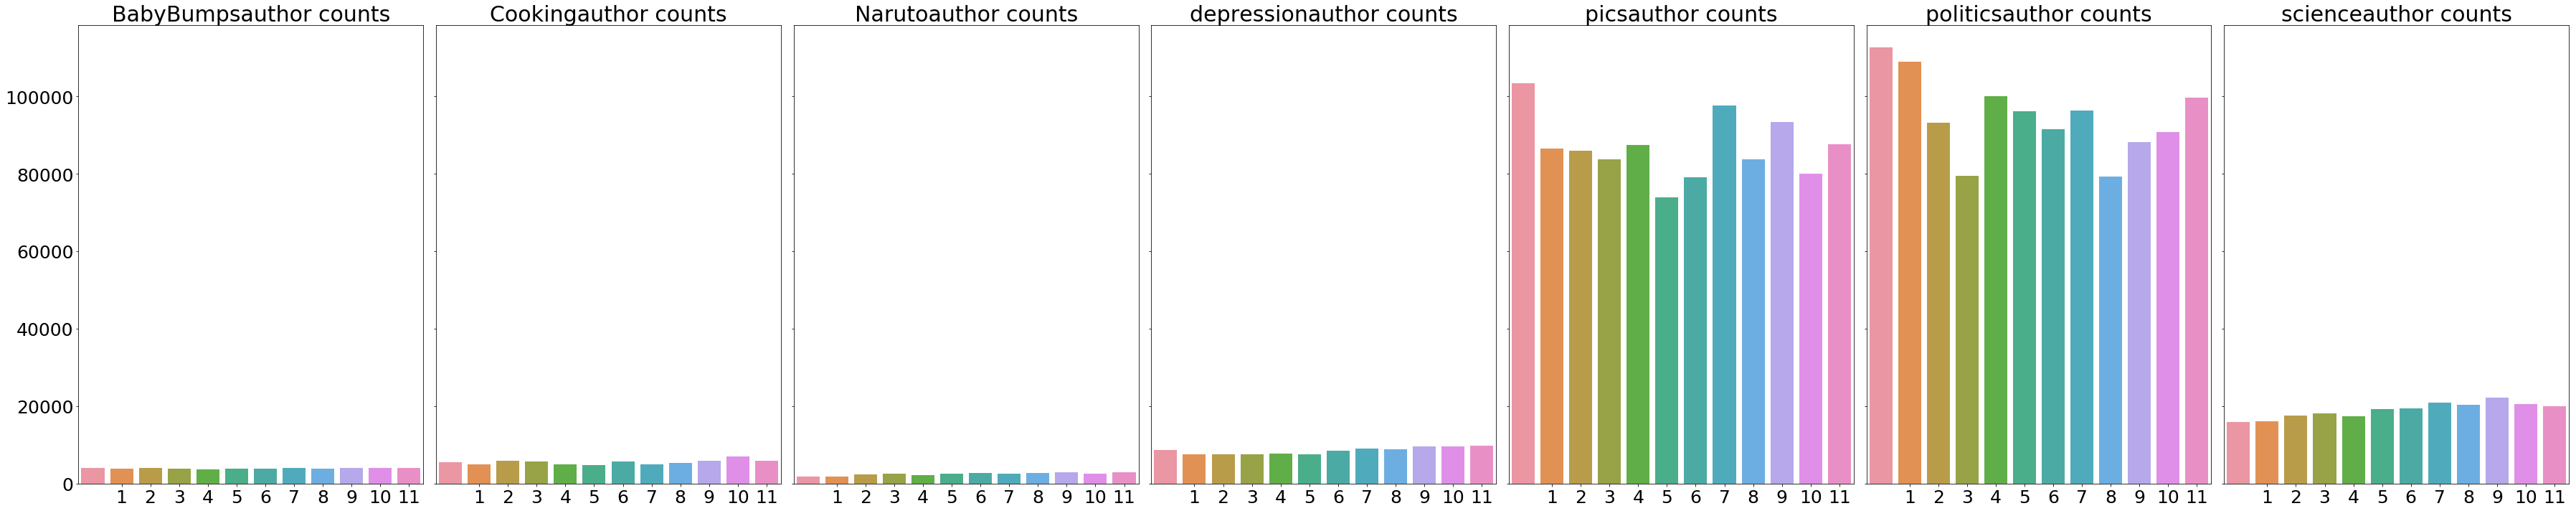

In [71]:

    
# sub_groups = df_comments_cleaned.groupby('subreddit')
# fig, axs = plt.subplots(1, len(sub_groups), sharey=True, tight_layout=True)
# fig.set_figheight(10)
# fig.set_figwidth(50)
# for i, (sub, g) in enumerate(sub_groups):
#     author_counts = get_author_counts(g)
#     plot_author_counts(author_counts, axs[i], sub)
        


# Vocab saving
Build a text file containing all words to build a vocab for our language model

array(['Cooking', 'mentalhealth', 'Seahawks', 'BabyBumps', 'science',
       'politics', 'news', 'EverythingScience', 'RoastMe'], dtype=object)